# Coursework 1 Section 2

## Imports and initial class and function definitions for later use:

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from tqdm import tqdm

In [2]:
# define a class h_sv, with inputs v, s
# v is number nearest neighbours, s is number of data points generated
# use the method .function(x) to output the assigned class of a test point
# x, which should be a 2 by 1 numpy array
# you must run train first before it's useful

class h_sv:

    def __init__(self,v,s):
        self.v = v
        self.s = s

    def train(self):

    # first generate s random centres with random labels

        self.features = pd.DataFrame()
        self.features['x'] = [np.random.random_sample() for i in range(self.s)]
        self.features['y'] = [np.random.random_sample() for i in range(self.s)]
        self.features['class'] = [np.random.randint(0,2) for i in range(self.s)]

    # now split the dataframe based on label

        self.zeros = self.features[self.features['class'] == 0]
        self.ones = self.features[self.features['class'] == 1]

    # now define the function that outputs the class of a test point

    def function(self, test):

        # create a dataframe with the squared distances of each point to the test point
        self.distances = pd.DataFrame()
        self.distances['dist'] = (self.features['x']-test[0])**2 + (self.features['y']-test[1])**2
        self.distances['class'] = self.features['class']

        # create an array with the classes of the closest v neighbours

        self.min_distance_class = np.zeros([self.v])

        for i in range(self.v):
            index = self.distances['dist'].idxmin()
            self.min_distance_class[i] = self.distances['class'][index]
            self.distances.drop(index)
        
        # now find the mean class label of the first v classes:

        self.mean = self.min_distance_class.sum()/self.v

        # now output class prediction:

        if self.mean > 0.5:
            return 1
        
        elif self.mean < 0.5:
            return 0

        # output either 1 or 0 randomly in the undefined class case
        else:
            return np.random.binomial(1,0.5)

In [3]:
# define a class generator, with inputs (N,p)
# this class takes a random h_sv with parameters (3,100),
# calculates the random decision regions for this h_sv
# and generates N samples based on these decision regions,
# but only assigns the correct class a fraction p of the time,
# the rest of the time it assigns the class with a 50/50 probability

# you must run .generate() first before it's useful
# this outputs a dataframe with coordinates and labels
# which can be accessed using .features

class generator:
    def __init__(self,N,p):
        self.N = N
        self.p = p
        self.h_sv = h_sv(3,100)
        self.h_sv.train()
    
    def generate(self):

        # generate N random points
        self.features = pd.DataFrame()
        self.features['x'] = [np.random.random_sample() for i in range(self.N)]
        self.features['y'] = [np.random.random_sample() for i in range(self.N)]

        # for each datapoint, do a coin toss with p=0.8 success
        # if successful, use correct class from hsv
        # if wrong, randomly generate class

        self.classlist = []

        for i in range(self.N):

            if np.random.binomial(1,0.8) == 1:
                output = self.h_sv.function([self.features['x'][i],self.features['y'][i]])
                self.classlist.append(output)

            else:
                self.classlist.append(np.random.randint(0,2))

        self.features['class'] = self.classlist

In [4]:
# define a class knn with inputs k, and a dataframe containing
# the features and labels for the training data,
# and has a function method that outputs the
# predicted class label for a given test point
# the input dataframe must have columns 'x', 'y', and 'class'
# it also has a function returning the generalised error for a test set
# which must also be input as a dataframe

class knn:
    def __init__(self,k,df):
        self.k = k
        self.df = df

    def function(self, point):

        # create a dataframe with the squared distances of each point to the test point
        self.distances = pd.DataFrame()
        self.distances['dist'] = (self.df['x']-point[0])**2 + (self.df['y']-point[1])**2
        self.distances['class'] = self.df['class']

        # create an array with the classes of the closest k neighbours

        self.min_distance_class = np.zeros([self.k])

        for i in range(self.k):
            index = self.distances['dist'].idxmin()
            self.min_distance_class[i] = self.distances['class'][index]
            self.distances.drop(index)

        # now find the mean class label of the first k classes:

        self.mean = self.min_distance_class.sum()/self.k

        
        # now output class prediction:

        if self.mean > 0.5:
            return 1
        
        elif self.mean < 0.5:
            return 0

        # output either 1 or 0 randomly in the undefined class case
        else:
            return np.random.binomial(1,0.5)

    # create a .generalisation_error() function which takes in a
    # dataframe of test points, runs .function() on each point
    # and calculates the average error
    def generalisation_error(self, test):
        self.error = 0
        length = len(test.index)
        for i in range(length):
            if test['class'][i] != self.function([test['x'][i],test['y'][i]]):
                self.error += 1
        self.error = self.error / length
        return self.error

In [5]:
# define a function that takes inputs k, m,
# that generates m + 1000 random points
# from a random instantiation of our generator,
# then splits this into 1000 test points and m training points.
# note it doesn't need to do a test - train shuffle as they are random anyway.
# then it does knn on this training data and calculates the 
# generalisation error on 1000 test points and returns this error.

def run(k,m):

    # generate training and test data
    data = generator(m + 1000, 0.8)
    data.generate()
    training_data = data.features[:m].copy()
    test_data = data.features[m:m+1000].copy()
    test_data.index = np.arange(0,1000)

    # create a knn class with the training data
    # and calculate the training error and test error
    nearest = knn(k,training_data)
    return nearest.generalisation_error(test_data)

## 6. Produce a visualisation of an h_sv

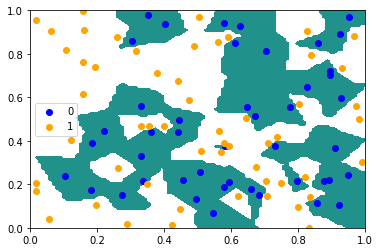

In [6]:
# instantiate an instance of h_sv

example_h_sv = h_sv(3,100)
example_h_sv.train()

# plot the shaded areas based on the classification of points
num = 100 

x, y = np.linspace(0,1,num), np.linspace(0,1,num)
xx, yy = np.meshgrid(x, y)
outputs = np.array([[example_h_sv.function(np.array([x[i],y[j]])) for i in range(num)] for j in range(num)])
plt.figure(1)
plt.contourf(xx, yy, outputs, levels=[-0.5,0.5])

# plot a scatter graph of random points

plt.scatter(example_h_sv.zeros['x'], example_h_sv.zeros['y'], label = '0', c = 'blue')
plt.scatter(example_h_sv.ones['x'], example_h_sv.ones['y'], label = '1', c = 'orange')

plt.legend()
plt.show()
plt.close()

## 7. Estimate the generalisation error as a function of k

In [7]:
# run the function 100 times for k = 1:49 and m = 4000
errors = []
for a in range(49):
    error = 0
    for b in range(2): # change this to 100
        error += run(a+1, 4000)
    error /= 2 # change to 100
    errors.append(error)

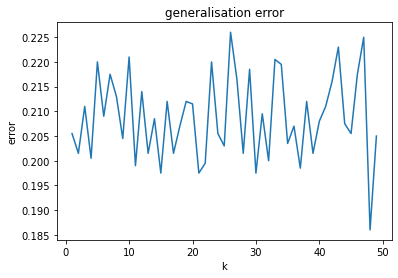

In [8]:
# now plot the above errors

plt.figure(2)
plt.plot(np.arange(1,50), errors)
plt.xlabel('k')
plt.ylabel('error')
plt.title('generalisation error')
plt.show()
plt.close()

## 8. Determine the optimal k as a function of the number of training points

In [9]:
# calculate the optimal value of k using protocol B

listm = [100,500,1000,1500,2000,2500,3000,3500,4000]
avg_optimal_k_list = []

# run for each m in the above list
for m in listm:
    avg_optimal_k = 0

    # run 100 times
    for b in range(2):
        newerrors = []

        # run for each k
        for c in range(49):
            newerrors.append(run(c+1, m))

        # find the value of k that minimised the generalisation error
        optimal_k = newerrors.index(min(newerrors)) + 1
        avg_optimal_k += optimal_k

    avg_optimal_k /= 2 # change to 100
    avg_optimal_k_list.append(avg_optimal_k)

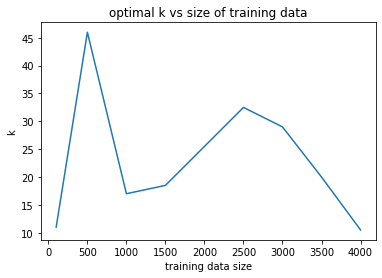

In [10]:
# plot the results for optimal k vs m

plt.figure(3)
plt.plot(listm, avg_optimal_k_list)
plt.xlabel('training data size')
plt.ylabel('k')
plt.title('optimal k vs size of training data')
plt.show()
plt.close()